У моделей линейной регрессии довольно много преимуществ. Во-первых, их легко обучать, процесс подбора коэффициентов довольно не сложная математическая операция и даже на больших данных такие модели обучаются довольно быстро. Их довольно легко интерпретировать (например, при единичном увеличении числа комментариев, которые человек написал на степике, вероятность его ухода с курса изменяется на столько-то). Но у линейных регрессионных моделей есть довольно большие недостатки и ограничения. Эти модели отлично себя показывают, когда мы решаем задачу классификации линейно разделимых классов (границу между точками можно провести с помощью прямой линии) или между нашими переменными существует строгая линейная взаимосвязь (в задачах предсказания). К тому же, должны выполняться ограничения: нормальное распределение остатков, гомоскедастичность, линейная зависимость переменных. Поэтому, когда мы решаем задачи более сложные, чем линейные зависимости, линейные модели показывают себя не очень здорово.

In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [3]:
from IPython.display import HTML
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

In [4]:
data =  pd.DataFrame({
    'X_1': [1, 1, 1, 0, 0, 0, 0, 1],
    'X_2': [0, 0, 0, 1, 0, 0, 0, 1],
    'Y': [1, 1, 1, 1, 0, 0, 0, 0]
    })

In [5]:
data

X_1  X_2  Y
0    1    0  1
1    1    0  1
2    1    0  1
3    0    1  1
4    0    0  0
5    0    0  0
6    0    0  0
7    1    1  0

Наша задача научиться (при помощи Дерева Решений) предсказывать значение переменной Y, основываясь на значениях переменных Х_1 и Х_2.

In [6]:
# классификатор - это некоторый объект, у которого есть методы
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [7]:
clf?

In [8]:
# Предобработка данных - сохраним все фичи в Х
X = data[['X_1', 'X_2']]
# Целевую переменную сохраним в y
y = data.Y

In [9]:
# Обучим наше Дерево Решений, для этого воспользуемся методом fit, передадим ему две переменные
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

##### Визуализировать дерево можно методом  plot_tree()

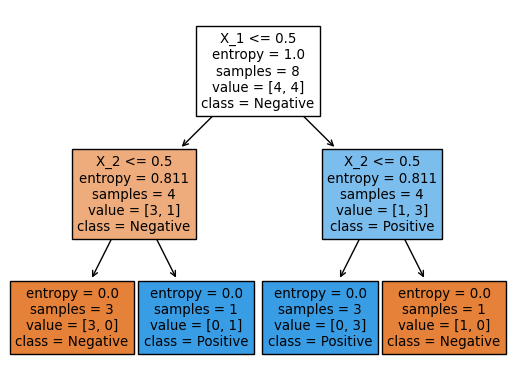

In [10]:
_ = tree.plot_tree(clf, feature_names=list(X),
               class_names=['Negative', 'Positive'],
               filled=True)
## _ - чтобы не отображались огромные аннотации для графика

##### Энтропия - уровень неопределенности данных.

Энтропия - мера беспорядка. Чем выше энтропия, тем хуже получается разделить классы.
В бинарной классификации энтропия находится от 0 до 1.

0 - Когда классы можно однозначно разделить

1 - Когда полный хаус и нет представления как разделить классы

S0 - в формулах обозначается как полная энтропия,
S1,S2 - в формулах обозначается как условная энтропия, для конкретного условия разделения выборки (X <=12)
E(S) это тоже самое, что и S0

##### Формула энтропии из математики

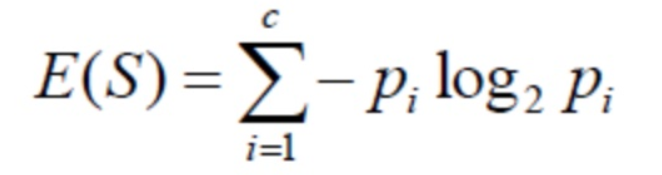

E(S) - полная энтропия, вычисляется изначально перед классификацией.

Формула энтропия для нашего случая с бинарной классификацией

E(S) = -p *log2(p) - (1 - p) * log2(1 - p)

p - это отношение количества элементов 1 класса к сумме всех элементов обоих классов

Т.е. если у нас есть 2 класса: ХХХХ и ОООО, (вероятность, что следующий рандомный элемент будет принадлежать какому-то классу 1/2), то E = -1/2 * log2(1/2) - 1/2 * log2(1/2) = 1/2 + 1/2 = 1 У нас нет представления как разделить на классы.

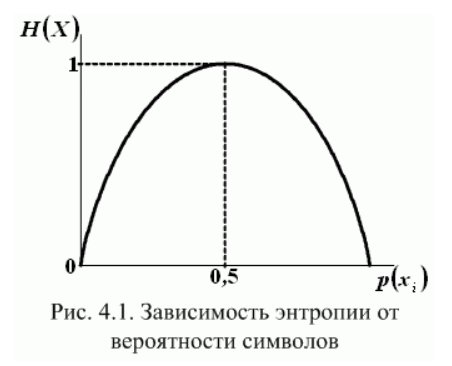

Т.е. чем больше в данных преобладание одного из классов, то тем сильнее энтропия стремится к 0.

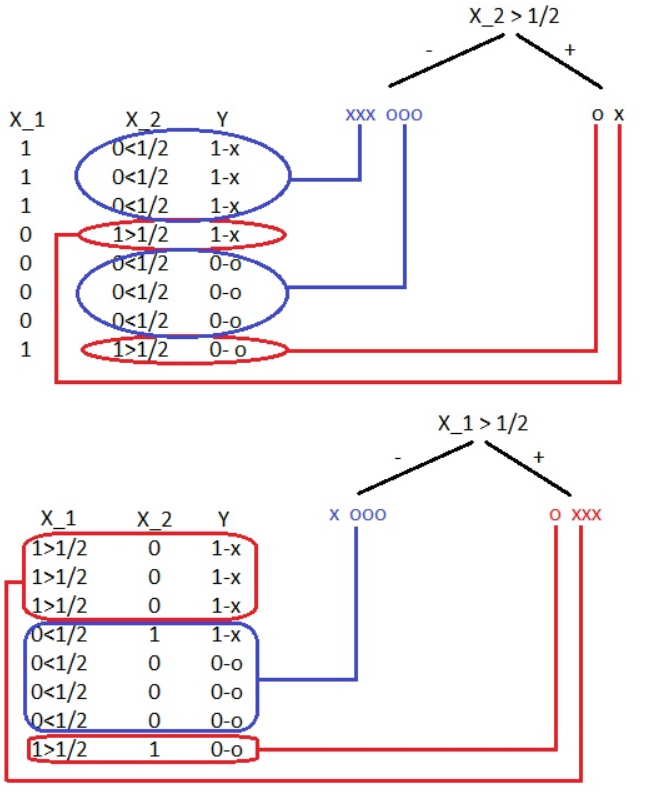

Сплитим сначала по Х2, считаем энтропию (Е=1, т.к. Р=1/2). Потом сплитим по Х1 и считаем Энтропию (Е=0.81, Р=1/4)

##### Условная энтропия:

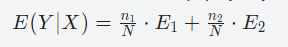

Дальше нам понадобится величина для измерения уменьшения этого беспорядка в дополнительной информации (признаках/независимых переменных) целевой переменной/класса. Вот тут в игру вступает Information Gain или информационный выигрыш. С точки зрения математики его можно записать так:

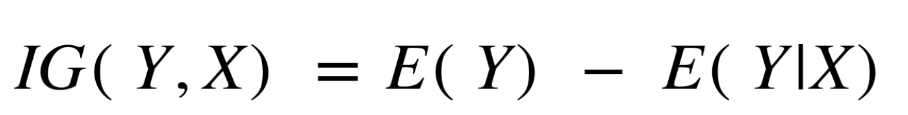

E(Y) - общая энтропия

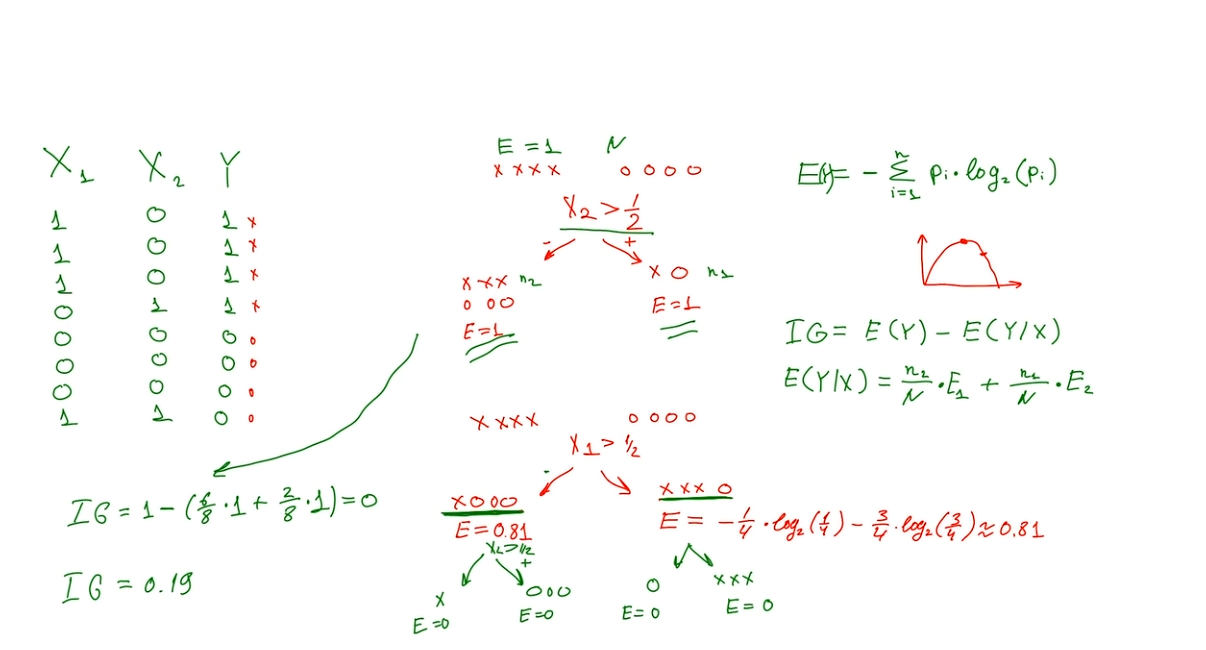

Начинаем с той переменной, у которой величина IG (выигрыша) больше. Т.е. с Х1 (0.19), дальше ветки сплитим по Х2 и пока не дойдем до энтропии = 0.

##### Алгоритм:

Решающее дерево поочередно сплитит по каждой фиче и считает Энтропию и Information Gain в каждом случае. Далее выбирается фича, у которой IG максимально. Сплитим по этой фиче. Далее в каждой ветке сплитится, ищется максимальный IG и выбирается оптимальеая фича для сплита. Пока не дойдем до состояния, когда все наблюдения идеально отнеслись к одному из 2 возможных классов (в бинарной классификации), значит неопределенности нет (Энтропия=0).


In [11]:
cats = pd.read_csv("https://stepik.org/media/attachments/course/4852/cats.csv", index_col=0)

In [12]:
cats

Шерстист  Гавкает  Лазает по деревьям      Вид
0         1        1                   0  собачка
1         1        1                   0  собачка
2         1        1                   0  собачка
3         1        1                   0  собачка
4         1        0                   1    котик
5         1        0                   1    котик
6         1        0                   1    котик
7         1        0                   1    котик
8         1        1                   1    котик
9         0        0                   1    котик

Энтропия при разделении по фиче Шерстист в группах:

In [13]:
import math

In [14]:
def entropy_cat_dog(cats, dogs):
    p_cats = cats / (cats + dogs)
    p_dogs = dogs / (cats + dogs)
    E_cats = -p_cats * math.log2(p_cats) if p_cats!=0 else 0
    E_dogs = -p_dogs * math.log2(p_dogs) if p_dogs!=0 else 0
    return E_cats + E_dogs

In [15]:
print('Шерстист=0', round(entropy_cat_dog(cats=1, dogs=0), 2) )

Шерстист=0 0.0


In [16]:
print('Шерстист=1', round(entropy_cat_dog(cats=5, dogs=4), 2) )

Шерстист=1 0.99


In [17]:
print('Гавкает=0', round(entropy_cat_dog(cats=5, dogs=0), 2) )

Гавкает=0 0.0


In [18]:
print('Гавкает=1', round(entropy_cat_dog(cats=1, dogs=4), 2) )

Гавкает=1 0.72


In [19]:
print('Лазает по деревьям=0', round(entropy_cat_dog(cats=0, dogs=4), 2) )

Лазает по деревьям=0 0.0


In [20]:
print('Лазает по деревьям=1', round(entropy_cat_dog(cats=6, dogs=0), 2) )

Лазает по деревьям=1 0.0


In [21]:
def info_gain(left_group, right_group, animals_total=10, entropy_original=entropy_cat_dog(cats=6, dogs=4)):
    e1 = sum( left_group.values() ) / animals_total * entropy_cat_dog(**left_group)  # **распаковываем словарь
    e2 = sum( right_group.values() ) / animals_total * entropy_cat_dog(**right_group)
    return entropy_original - (e1 + e2)

In [22]:
left_group = {'cats': 1, 'dogs': 0}
right_group = {'cats': 5, 'dogs': 4}
print('Split by feature Шерстист information gain: ', round(info_gain(left_group, right_group), 2) )

Split by feature Шерстист information gain:  0.08


In [23]:
left_group = {'cats': 5, 'dogs': 0}
right_group = {'cats': 1, 'dogs': 4}
print('Split by feature Гавкает information gain: ', round(info_gain(left_group, right_group), 2) )

Split by feature Гавкает information gain:  0.61


In [24]:
left_group = {'cats': 0, 'dogs': 4}
right_group = {'cats': 6, 'dogs': 0}
print('Split by feature Лазает information gain: ', round(info_gain(left_group, right_group), 2) )

Split by feature Лазает information gain:  0.97


##### Датасет Титаник

In [25]:
titanic_data = pd.read_csv('C:\\Users\\UserOfPC\\Downloads\\brunoyam\\data\\train.csv')

In [26]:
titanic_data.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

Посмотрим на сумму пропущенных значений. 

In [27]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Переменную Cabin можем исключить из наших данных (в связи с малой информативностью и большим количеством пропусков).

Заполним пропущенные значения в переменной age медианным значением возраста.

In [28]:
titanic_data = titanic_data.fillna({'Age': titanic_data.Age.median()})

In [29]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

В переменную Х запишем те фичи, которые будем использовать. В переменную у - переменную, которую будем предсказывать.

In [30]:
X_titanic = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

In [31]:
X_titanic.head(3)

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S

Закодируем строковые переменные. Воспользуемся удобный методом Пандаса - get_dummies(), который сам выбирает строковые переменные и кодирует их.

In [32]:
X_titanic = pd.get_dummies(X_titanic)
X_titanic.head(3)

Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  Embarked_C  \
0       3  22.0      1      0   7.2500           0         1           0   
1       1  38.0      1      0  71.2833           1         0           1   
2       3  26.0      0      0   7.9250           1         0           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1

In [33]:
y_titanic = titanic_data.Survived

In [34]:
clf_titanic = tree.DecisionTreeClassifier(criterion='entropy')

In [35]:
clf_titanic.fit(X_titanic, y_titanic)

DecisionTreeClassifier(criterion='entropy')

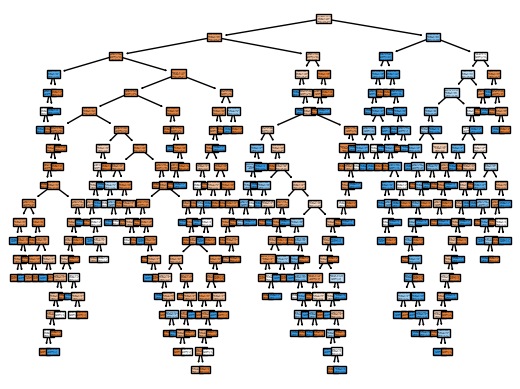

In [36]:
_ = tree.plot_tree(clf_titanic, feature_names=list(X_titanic),class_names=['Died', 'Survived'], filled=True)

Наблюдаем overfitting - очень сильное переобучение нашей модели. Модель будет сплитить до тех пор, пока полностью не классифицирует абсолютно всех пассажиров. Нам не так важно добиться 100% точности в реальных задачах классификации. 

##### Проблема переобучения - вместо того, чтобы выявить общую закономерность классификации, модель пытается безошибочно классифицировать каждое наблюдение в данной выборке (т.е. на другой выборке будет работать далеко не всегда корректно).

Мы можем ограничивать глубину дерева (количество вопросов). 

Разобьем наш датасет (X и y) на тестовую 33% и трейновую части с помощью метода train_test_split, для того, чтобы посмотреть насколько хорошо модель предсказывает ответы на трейне и тесте и сравним результаты.

In [37]:
X_train_tit, X_test_tit, y_train_tit, y_test_tit = train_test_split(X_titanic, y_titanic, test_size=0.33, random_state=42)   
#брать за random_state число 42 - "традиция"

Показатель результативности модели - score - количество правильных ответов.

In [38]:
clf_titanic.score(X_titanic, y_titanic)

0.9797979797979798

In [39]:
clf_titanic.score(X_train_tit, y_train_tit)

0.9714765100671141

Затем обучим нашу модель только на трейновой выборке.

In [40]:
clf_titanic.fit(X_train_tit, y_train_tit)

DecisionTreeClassifier(criterion='entropy')

In [41]:
clf_titanic.score(X_train_tit, y_train_tit)

0.9798657718120806

In [42]:
clf_titanic.score(X_test_tit, y_test_tit)

0.7627118644067796

Можем наблюдать, что точность классификации на обучающем множестве 98%. А результат на тех данных, которые модель не видела - сильно хуже, всего 77%. Возможно проблема в том, что дерево переобучилось. Т.е. вместо того, чтобы вычленить некоторую закономерность в данных, обобщить и применить на новых данных, дерево пыталось как можно лучше решить частную задачу - классифицировать все данные на конкретной выборке. Попробуем ограничить глубину дерева с помощью добавления в можель параметра max-depth. 

In [43]:
clf_titanic = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [44]:
clf_titanic.fit(X_train_tit, y_train_tit)   #обучим на трейне

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [45]:
clf_titanic.score(X_train_tit, y_train_tit)

0.8238255033557047

In [46]:
clf_titanic.score(X_test_tit, y_test_tit)

0.8203389830508474

На обучающей выборке классификатор стал работать хуже. Однако на данных, которые модель не видела, точность стала выше, что для нас очень важно.

Посмотрим при каком значении max_depth точность модели на трейновой/тестовой выборках будет лучшей. Для этого в цикле будем перебирать разные значения max_depth 

In [47]:
max_depth_values = range(1, 100)

In [48]:
scores_data = pd.DataFrame()

In [49]:
for max_depth in max_depth_values:
    clf_titanic = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf_titanic.fit(X_train_tit, y_train_tit)   
    train_score = clf_titanic.score(X_train_tit, y_train_tit)   
    test_score = clf_titanic.score(X_test_tit, y_test_tit)   
    
    # Будем записывать все значения в Датафрейм temp_score_data
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score': [test_score]})
    
    # Будем добавлять все наши датафреймы в один датафрейм scores_data
    #scores_data = scores_data.append(temp_score_data)  метод append устарел, используесм вместо него pd.concat
    scores_data = pd.concat([scores_data, temp_score_data])  

In [50]:
scores_data.head()

max_depth  train_score  test_score
0          1     0.781879    0.796610
0          2     0.805369    0.776271
0          3     0.823826    0.820339
0          4     0.833893    0.823729
0          5     0.840604    0.810169

Задача - изобразить на графике зависимость точности от глубины, и сделать это двумя линиями (train и test).

Нужно преобразовать scores_data так, чтобы для каждой строки были созданы 2 новые: одна со значением точности на тренировочных данных, другая на тестовых.

In [51]:
# метод melt - 'плавим' датафрейм, изменяем структуру (сплавим 2 столбца в 1)
# id_vars - отвечает за группировку
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score')

In [52]:
scores_data_long.head()

max_depth     set_type     score
0          1  train_score  0.781879
1          2  train_score  0.805369
2          3  train_score  0.823826
3          4  train_score  0.833893
4          5  train_score  0.840604

Далее построим график: две кривые с группировокой по set_type.

<Axes: xlabel='max_depth', ylabel='score'>

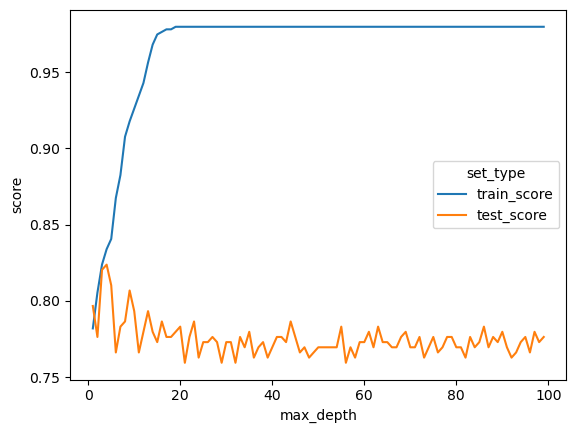

In [53]:
sns.lineplot(data=scores_data_long, x="max_depth", y="score", hue="set_type")

На обучающей выборке с увеличением глубины дерева модель все лучше начинает классифицировать данные.

Ситуация на тестовой выборке - другая. На промежутке max_depth от 3 до 5, score - максимальный. А дальше, с увеличением max_depth, test_score начинает постепенно снижаться. Модель начинает переобучаться.

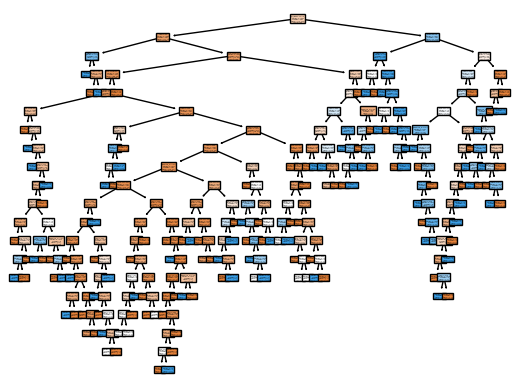

In [54]:
_ = tree.plot_tree(clf_titanic, feature_names=list(X_test_tit),class_names=['Died', 'Survived'], filled=True)

Так выглядит возможный пример дерева с параметром максимальной глубины равным 3. Легко можно заметить, что особенно важными переменными для анализа является пол и возраст.

Тут же обратите внимание на еще один важный момент, если бы к нам поступил новый пассажир, и мы бы захотели, предсказать для него не только значение класса но и вероятность, того что он выживет на Титанике, это было бы несложно сделать при помощи нашего дерева. Обратите внимание, цвет финальных прямоугольничков различается, соотношение выживших/погибших пассажиров различается в финальных исходах - прямоугольничках. 

Например, если бы к нам пришло новое наблюдение Sex_male <=0.05, Pclass <= 2.5, Age > 2.5,  то предсказанная вероятность выжить была бы равна 102 / (102 + 3), то есть 97%. 

Но давайте сразу поймем, что с нашим деревом не так? Обратите внимание, что данное дерево все равно выглядит переобученным, например, есть разделение, которое приводит к тому, что под условие Age <= 2.5 проходит всего два наблюдения с разными классами, запомним эту проблему деревьев и вернемся к ней позже.

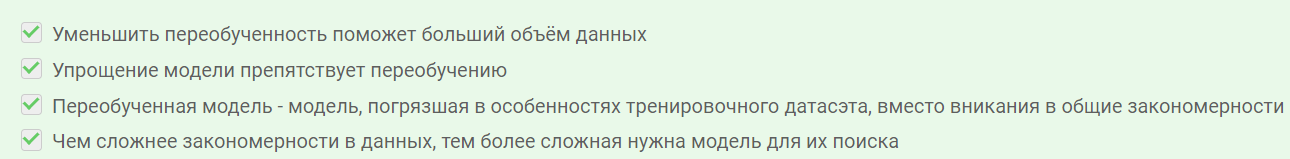

Если мы хотим получить действительно обощенную закономерность в данных, мы не должны злоупотреблять сравнением трейна и теста, чтобы модель не переобучилась. На тестовой выборке мы подбираем параметры, "оптимальные" для обучения модели. И когда тестовая выборка одна и та же для всех параметров, то выбранные "лучшие" параметры по сути являются лучшими только для конкретной тестовой выборки, а не для всех возможных данных в целом. Т.е. итоговая модель хорошо обобщает не все закономерности данных, а только закономерности, предоставленные в конкретной обучающей и конкретной тестовой выборках, а это аналогично переобучению.

##### Кросcвалидация - 
Один из способов избежать переобучения.

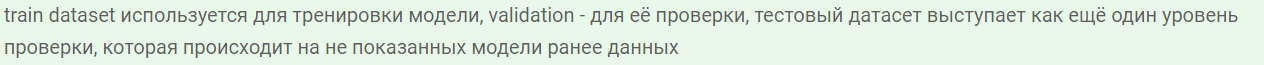

У нас есть 2 документа с данными, train.csv и test.csv. 

test.csv - не содержит целевой переменной и мы ее предсказываем.

train.csv, его мы делим  на тренировочные данные и тестовые данные. Тестовые данные мы откладываем, а тренировочные данные делим на 5 частей (в каждой части: 4 части - трейн и 1 часть - тест), далее производится кросс-валидация (усредненные данные).

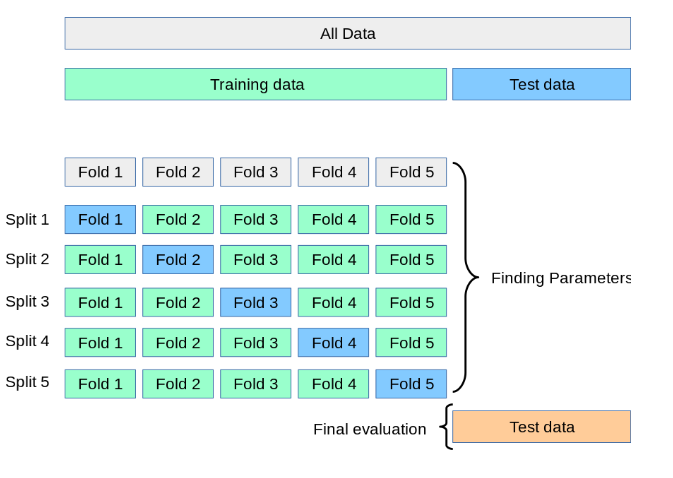

In [55]:
from sklearn.model_selection import cross_val_score

In [56]:
clf_titanic = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [57]:
cross_val_score(clf_titanic, X_train_tit, y_train_tit, cv=5).mean() # разбивка на 5 фолдов и подсчет итоговой средней точности

0.7886274509803922

Внесем корректировки в прошлый код, учитывая кросс-валидацию.

In [58]:
scores_data = pd.DataFrame()   # создадим новый датафрейм, чтобы не перезаписывался в старый

In [59]:
for max_depth in max_depth_values:
    clf_titanic = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf_titanic.fit(X_train_tit, y_train_tit)   
    train_score = clf_titanic.score(X_train_tit, y_train_tit)   
    test_score = clf_titanic.score(X_test_tit, y_test_tit)   
    mean_cross_val_score = cross_val_score(clf_titanic, X_train_tit, y_train_tit, cv=5).mean()
    
    # Будем записывать все значения в Датафрейм temp_score_data
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    
    # Будем добавлять все наши датафреймы в один датафрейм scores_data
    #scores_data = scores_data.append(temp_score_data)  метод append устарел, используесм вместо него pd.concat
    scores_data = pd.concat([scores_data, temp_score_data])  

In [60]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score')
scores_data_long.head()

max_depth     set_type     score
0          1  train_score  0.781879
1          2  train_score  0.805369
2          3  train_score  0.823826
3          4  train_score  0.833893
4          5  train_score  0.840604

<Axes: xlabel='max_depth', ylabel='score'>

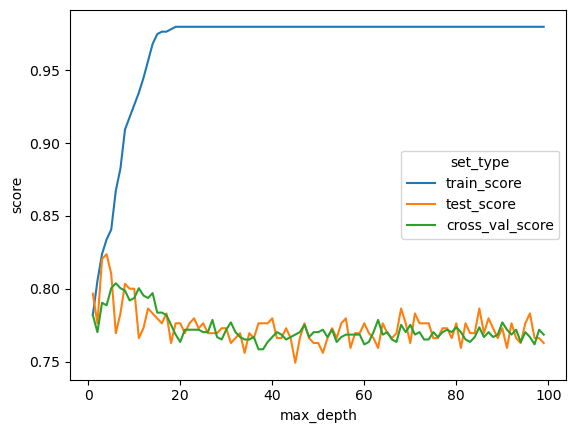

In [61]:
sns.lineplot(data=scores_data_long, x="max_depth", y="score", hue="set_type")

Максимальная точность на кросс-валидации достигается при большей глубине дерева. Дерево, которое дало максимальный показатель на cross_val_score нас и интересует.

In [62]:
scores_data_long.query(" set_type == 'cross_val_score' ").head(16)

max_depth         set_type     score
198          1  cross_val_score  0.781961
199          2  cross_val_score  0.770196
200          3  cross_val_score  0.790322
201          4  cross_val_score  0.788627
202          5  cross_val_score  0.800392
203          6  cross_val_score  0.803754
204          7  cross_val_score  0.800378
205          8  cross_val_score  0.798683
206          9  cross_val_score  0.791947
207         10  cross_val_score  0.793627
208         11  cross_val_score  0.800350
209         12  cross_val_score  0.795336
210         13  cross_val_score  0.793627
211         14  cross_val_score  0.797003
212         15  cross_val_score  0.783585
213         16  cross_val_score  0.783613

Видим, что максимальная точность достигается при глубине дерева = 10. Создадим новый классификатор и протестим его финально (с глубиной 10) на тестовых данных, которые наш классификатор еще ни разу не видел.

In [63]:
clf_titanic = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [64]:
cross_val_score(clf_titanic, X_test_tit, y_test_tit, cv=5).mean()

0.7966101694915254

### GridSearchCV

Ключевая функция по обучению моделей, при помощи кросс-валидации отбирает такую комбинацию параметров, которые дают максимальный результат (результат тоже выбираемый: accuracy, f1, precision, recall, roc_auc). Автоматизированный подбор параметров.

In [65]:
clf_titanic = tree.DecisionTreeClassifier()
?clf

In [66]:
# Создадим словарь с параметрами, которые хотим "потюнить"
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}

In [67]:
# В GridSearchCV передадим наш пустой классификатор и словарик с параметрами, 
# cv=5 фолдов для кросс-валидации
grid_search_cv_clf = GridSearchCV(clf_titanic, parametrs, cv=5)

In [68]:
# Обучаем не первоначальную модель clf, а модель на основе GridSearchCV
grid_search_cv_clf.fit(X_train_tit, y_train_tit)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [69]:
# Выбираем best_params_ прогоняя на кросс-валидации, выбираяя лучший accuracy не просто на обучающей выборке, 
# а на кросс-валидационном множестве
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [70]:
# аттрибут модели best_estimator_ - дерево с лучшими параметрами
best_clf = grid_search_cv_clf.best_estimator_

In [71]:
best_clf.score(X_test_tit, y_test_tit)

0.7898305084745763

Но! Когда у нас есть дисбаланс классов смотреть на точность в бинарной классификации не верное решение. Будем использовать другие метрики.

In [72]:
y_pred_tit = best_clf.predict(X_test_tit)

In [73]:
precision_score(y_test_tit, y_pred_tit)

0.8020833333333334

In [74]:
recall_score(y_test_tit, y_pred_tit)

0.6416666666666667

recall получился меньше, значит модель чаще "недорабатывает", делает ошибки типа FN, не относит к классу выживших тех пассажиров, которые на самом деле выжили. 

In [75]:
# с помощью методом predict_proba (для каждого пассажира предсказана вероятность отнесения его к одному или другому классу
y_predicted_prob = best_clf.predict_proba(X_test_tit)

Отсечка классов - 0.5

<Axes: >

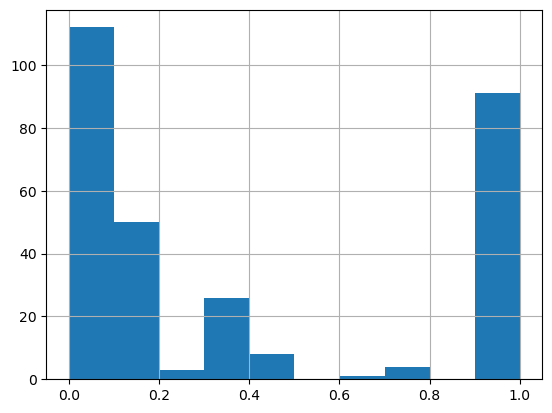

In [76]:
pd.Series(y_predicted_prob[:, 1]).hist()

Но допустим, мы хотели бы, чтобы в класс выживших попадали с вероятностью 0.8, поэтому ее можно менять и смотреть на результат.

In [77]:
y_pred_tit = np.where(y_predicted_prob[:, 1] > 0.5, 1, 0)

In [78]:
precision_score(y_test_tit, y_pred_tit)

0.8020833333333334

In [79]:
recall_score(y_test_tit, y_pred_tit)

0.6416666666666667

##### RandomizedSearchCV

Чем больше данных, сложность модели и число её параметров, тем дольше будет вестись поиск GridSearchCV. Однако бывают случаи, когда модель нужна здесь и сейчас, и для этого есть RandomizedSearchCV! Пробегаясь по рандомной подвыборке параметров, он ищет наиболее хорошую модель и делает это быстрее полного перебора параметров, хотя и может пропустить оптимальные параметры.

##### Как найти баланс между метриками? ROC - кривая

Часто результат работы алгоритма на фиксированной тестовой выборке визуализируют с помощью ROC-кривой (ROC = receiver operating characteristic, иногда говорят «кривая ошибок»), а качество оценивают как площадь под этой кривой – AUC (AUC = area under the curve)

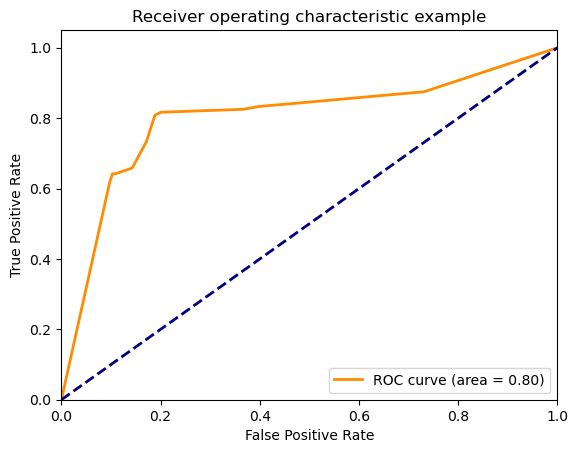

In [80]:
fpr, tpr, thresholds = roc_curve(y_test_tit, y_predicted_prob[:, 1])
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

True Positive Rate - Recall - какой % пассажиров, которые выжили, мы действительно классифицировали как выживших. (TP/(TP+FN), данные первого столбца матрицы) 

False Positive Rate - как часто мы пассажиров, которые не выжили классифицировали как выживших. (1- True Positive Rate = FP/(FP+TN), данные второго столбца матрицы)

Чем хуже работает наш классификатор, тем ближе кривая будет к диагональной линии. Диагональ - означает, что доля корректно классифицированных объектов = доле ошибочно классифицированных.

Считаем от самого нижнего порога 0.1 для разделения классов, получаем True Positive Rate=1 и False Positive Rate=1 откладываем первую точку на кривой, далее аналогично увеличиваем порог.

На нашем графике видим, что третья точка гораздо лучше: True Positive Rate у нее ок. 0.85, а False Positive Rate ок. 02, так же она максимально далеко от диагонали.

Чем больше площадь под ROC-кривой, тем лучше ROC-кривая (при сравнении нескольких кривых). Можно выбирать лучшую модель, сравнивая ROC-кривые и площади под ними (AUC)

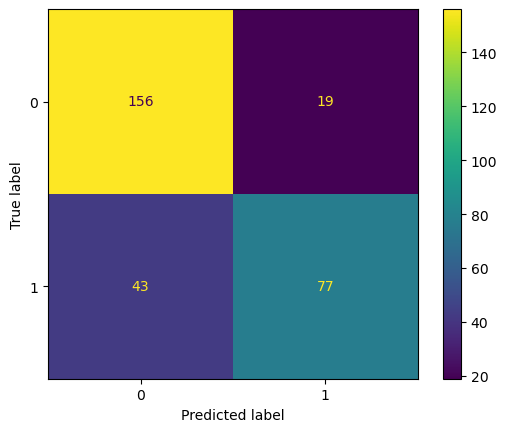

In [81]:
cm = confusion_matrix(y_test_tit, y_pred_tit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

ROC-кривая наглядно суммирует все информацию по разным матрицам-ошибок с разной пороговой вероятностью отнесения к классу.

##### ____________________________________________________________________________________

#### Пример на Датасете с Ирисами

Скачайте тренировочный датасэт с ирисами, обучите деревья с глубиной от 1 до 100. Целевой переменной при обучении является переменная species. При этом записывайте его скор (DecisionTreeClassifier.score()) на тренировочных данных, и аккуратность предсказаний (accuracy_score) на тестовом датасэте. Затем визуализируйте зависимость скора и аккуратности предсказаний от глубины дерева и выберите правильную визуализацию из предложенных.

Важно: задайте random seed прямо перед созданием дерева или укажите его в параметрах дерева (random_state=rs)

np.random.seed(0)
my_awesome_tree = DecisionTreeClassifier(...)
или

my_awesome_tree = DecisionTreeClassifier(random_state=0, ...)

In [82]:
Iris_data_train = pd.read_csv('C:\\Users\\UserOfPC\\Documents\\Основы Data Science Stepik\\Датасеты\\train_iris.csv')

In [83]:
Iris_data_test = pd.read_csv('C:\\Users\\UserOfPC\\Documents\\Основы Data Science Stepik\\Датасеты\\test_iris.csv')

In [84]:
Iris_data_test.head()

Unnamed: 0  sepal length  sepal width  petal length  petal width  species
0         114           5.8          2.8           5.1          2.4        2
1          70           5.9          3.2           4.8          1.8        1
2         138           6.0          3.0           4.8          1.8        2
3          59           5.2          2.7           3.9          1.4        1
4          44           5.1          3.8           1.9          0.4        0

In [85]:
Iris_data_train.isnull().sum()

Unnamed: 0      0
sepal length    0
sepal width     0
petal length    0
petal width     0
species         0
dtype: int64

In [86]:
X_train = Iris_data_train.drop(['species', 'Unnamed: 0'], axis = 1)

In [87]:
y_train = Iris_data_train.species

In [88]:
X_test = Iris_data_test.drop(['species', 'Unnamed: 0'], axis = 1)

In [89]:
y_test = Iris_data_test.species

In [90]:
rs = np.random.seed(0)  # переменная-рандомайзер

In [91]:
max_depth_values = range(1, 100)

In [92]:
scores_data = pd.DataFrame()

In [93]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rs)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
  
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score': [test_score]})
    
    scores_data = pd.concat([scores_data, temp_score_data])  

In [94]:
scores_data

max_depth  train_score  test_score
0           1         0.70        0.60
0           2         0.97        0.94
0           3         0.99        0.94
0           4         1.00        0.92
0           5         1.00        0.92
..        ...          ...         ...
0          95         1.00        0.92
0          96         1.00        0.92
0          97         1.00        0.92
0          98         1.00        0.94
0          99         1.00        0.92

[99 rows x 3 columns]

In [95]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score')
scores_data_long.head(3)

max_depth     set_type  score
0          1  train_score   0.70
1          2  train_score   0.97
2          3  train_score   0.99

<Axes: xlabel='max_depth', ylabel='score'>

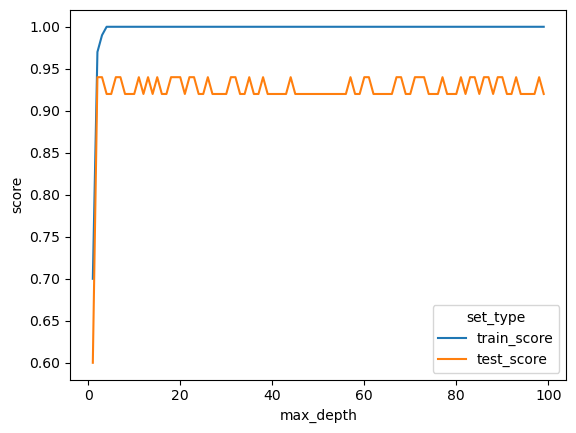

In [96]:
sns.lineplot(data=scores_data_long, x="max_depth", y="score", hue="set_type")

##### ___________________________________________________________________________

#### Пример cats & dogs
Мы собрали побольше данных о котиках и собачках, и готовы обучить нашего робота их классифицировать! Скачайте тренировочный датасэт и  обучите на нём Decision Tree. После этого скачайте датасэт из задания и предскажите какие наблюдения к кому относятся. Введите число собачек в вашем датасэте.

В задании допускается определённая погрешность.

P. S.: данные в задании находятся в формате json, используйте метод pd.read_json для их прочтения

In [97]:
cats_dogs_data = pd.read_csv('C:\\Users\\UserOfPC\\Documents\\Основы Data Science Stepik\\Датасеты\\dogs_n_cats.csv')

In [98]:
cats_dogs_data.head()

Длина  Высота  Шерстист  Гавкает  Лазает по деревьям      Вид
0     15    18.0         1        1                   0  собачка
1     20    24.0         1        0                   0  собачка
2     34    40.8         1        1                   0  собачка
3     26    31.2         1        1                   0  собачка
4     16    19.2         1        1                   0  собачка

In [99]:
cats_dogs_data.isnull().sum()

Длина                 0
Высота                0
Шерстист              0
Гавкает               0
Лазает по деревьям    0
Вид                   0
dtype: int64

In [100]:
X = cats_dogs_data.drop('Вид', axis=1)

In [101]:
y = cats_dogs_data['Вид']

In [102]:
clf_cat = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [103]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size=0.33, random_state=42) 

In [104]:
clf_cat.fit(X_train_cat, y_train_cat)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [105]:
train_score = clf_cat.score(X_train_cat, y_train_cat)
train_score

1.0

In [106]:
test_score = clf_cat.score(X_test_cat, y_test_cat)
test_score

1.0

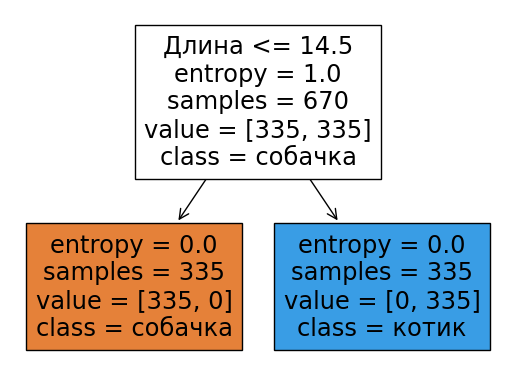

In [107]:
_ = tree.plot_tree(clf_cat, feature_names=list(X),
               class_names=['собачка', 'котик'],
               filled=True)

In [108]:
cats_dogs_test = pd.read_json('C:\\Users\\UserOfPC\\Documents\\Основы Data Science Stepik\\Датасеты\\dataset_209691_15 (3).txt')

In [109]:
cats_dogs_test.head()

Длина  Высота  Шерстист  Гавкает  Лазает по деревьям
0     18    21.6         1        1                   0
1     17    20.4         1        1                   0
2     34    40.8         1        1                   0
3     21    25.2         1        1                   0
4     22    26.4         1        0                   0

In [110]:
result = clf_cat.predict(cats_dogs_test)
result     # numpy массив

array(['собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'собачка', 'собачка', 'собачка',
       'собачка', 'собачка', 'собачка', 'котик', 'котик', 'котик',
       'котик', 'котик', 'котик', 'котик', 'котик', 'котик', 'котик',
       'котик', 'котик', 'котик', 'котик', 'котик', 'котик', 'котик',
       'котик', 'котик', 'котик', 'котик', 'котик', 'котик', 'котик',
       'котик', 'котик', 'котик', 'котик', 'котик', 'котик', 'котик',
       'котик', 'котик', 'котик', 'котик', 'котик', 'котик', 'котик',
       'котик', 'котик', 'котик', 'котик', 'котик', 'котик', 'котик',
  

In [111]:
np.sum(result == 'собачка')

45

##### ________________________________________________________________________________________________

### Метрики качества модели

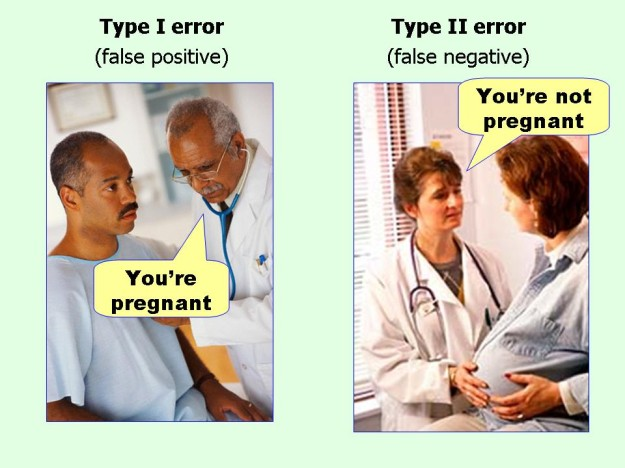

#### 1 тип ошибок - найти то, чего нет --  FALSE POSITIVE  (FP)
#### 2 тип ошибок - НЕ найти то, что есть   --  FALSE NEGATIVE (FN)

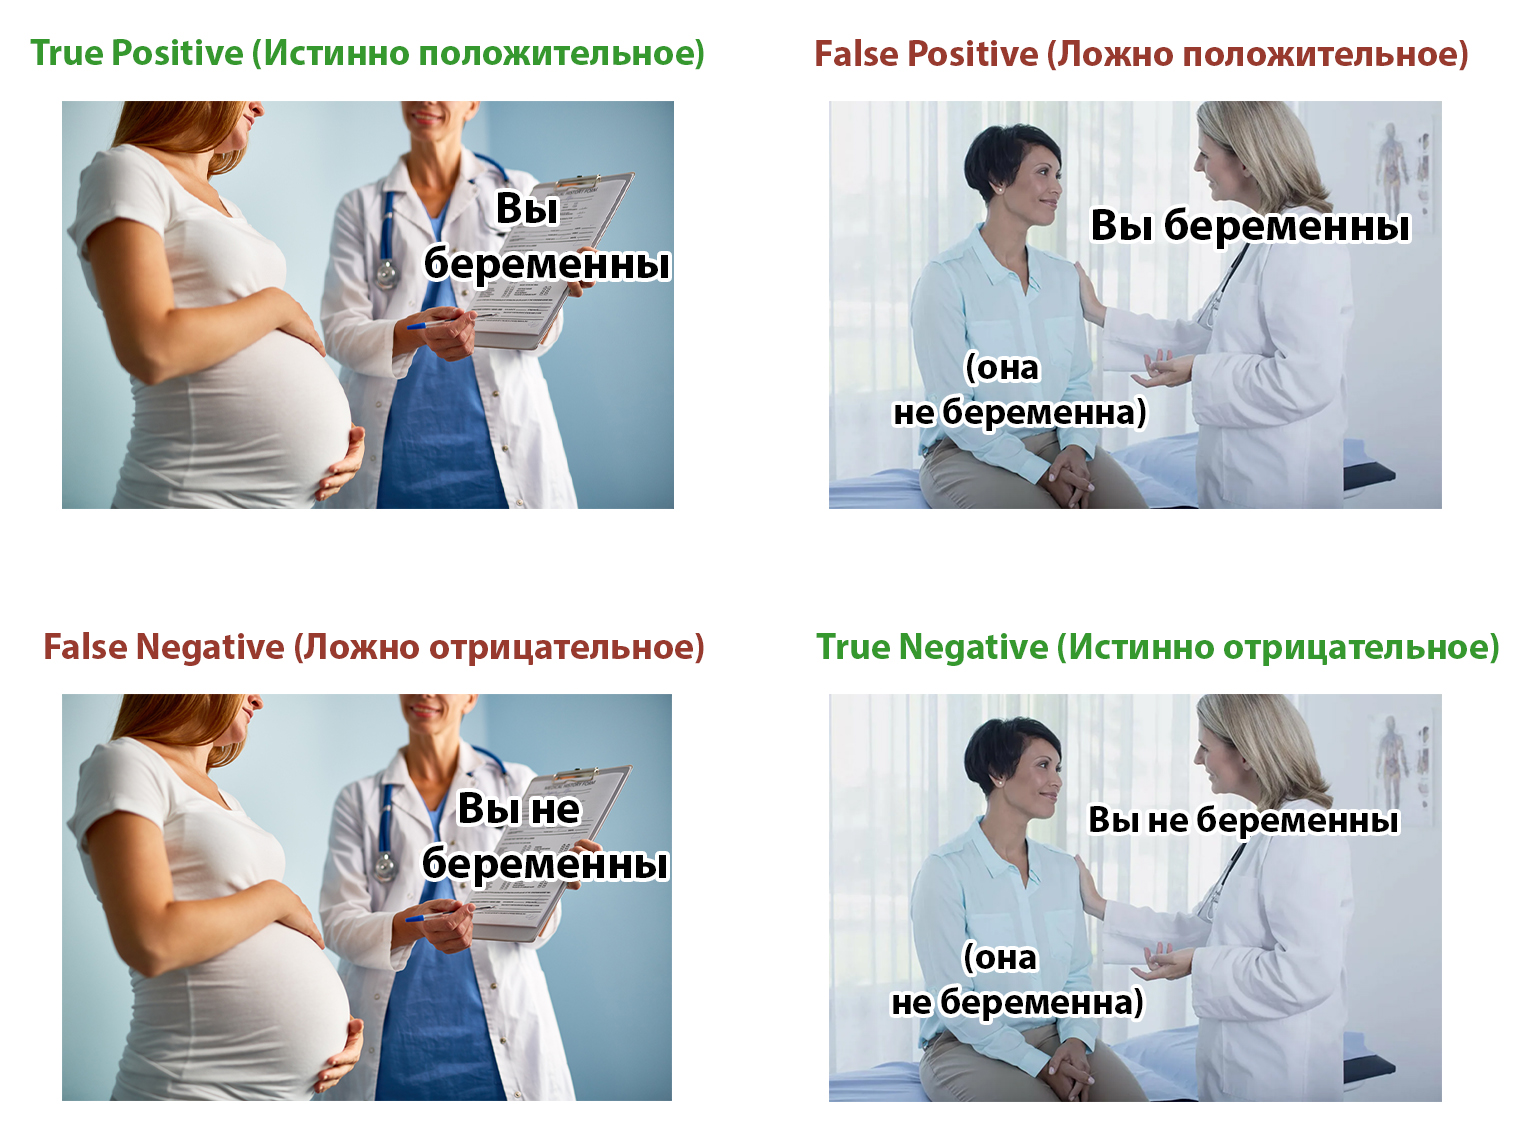

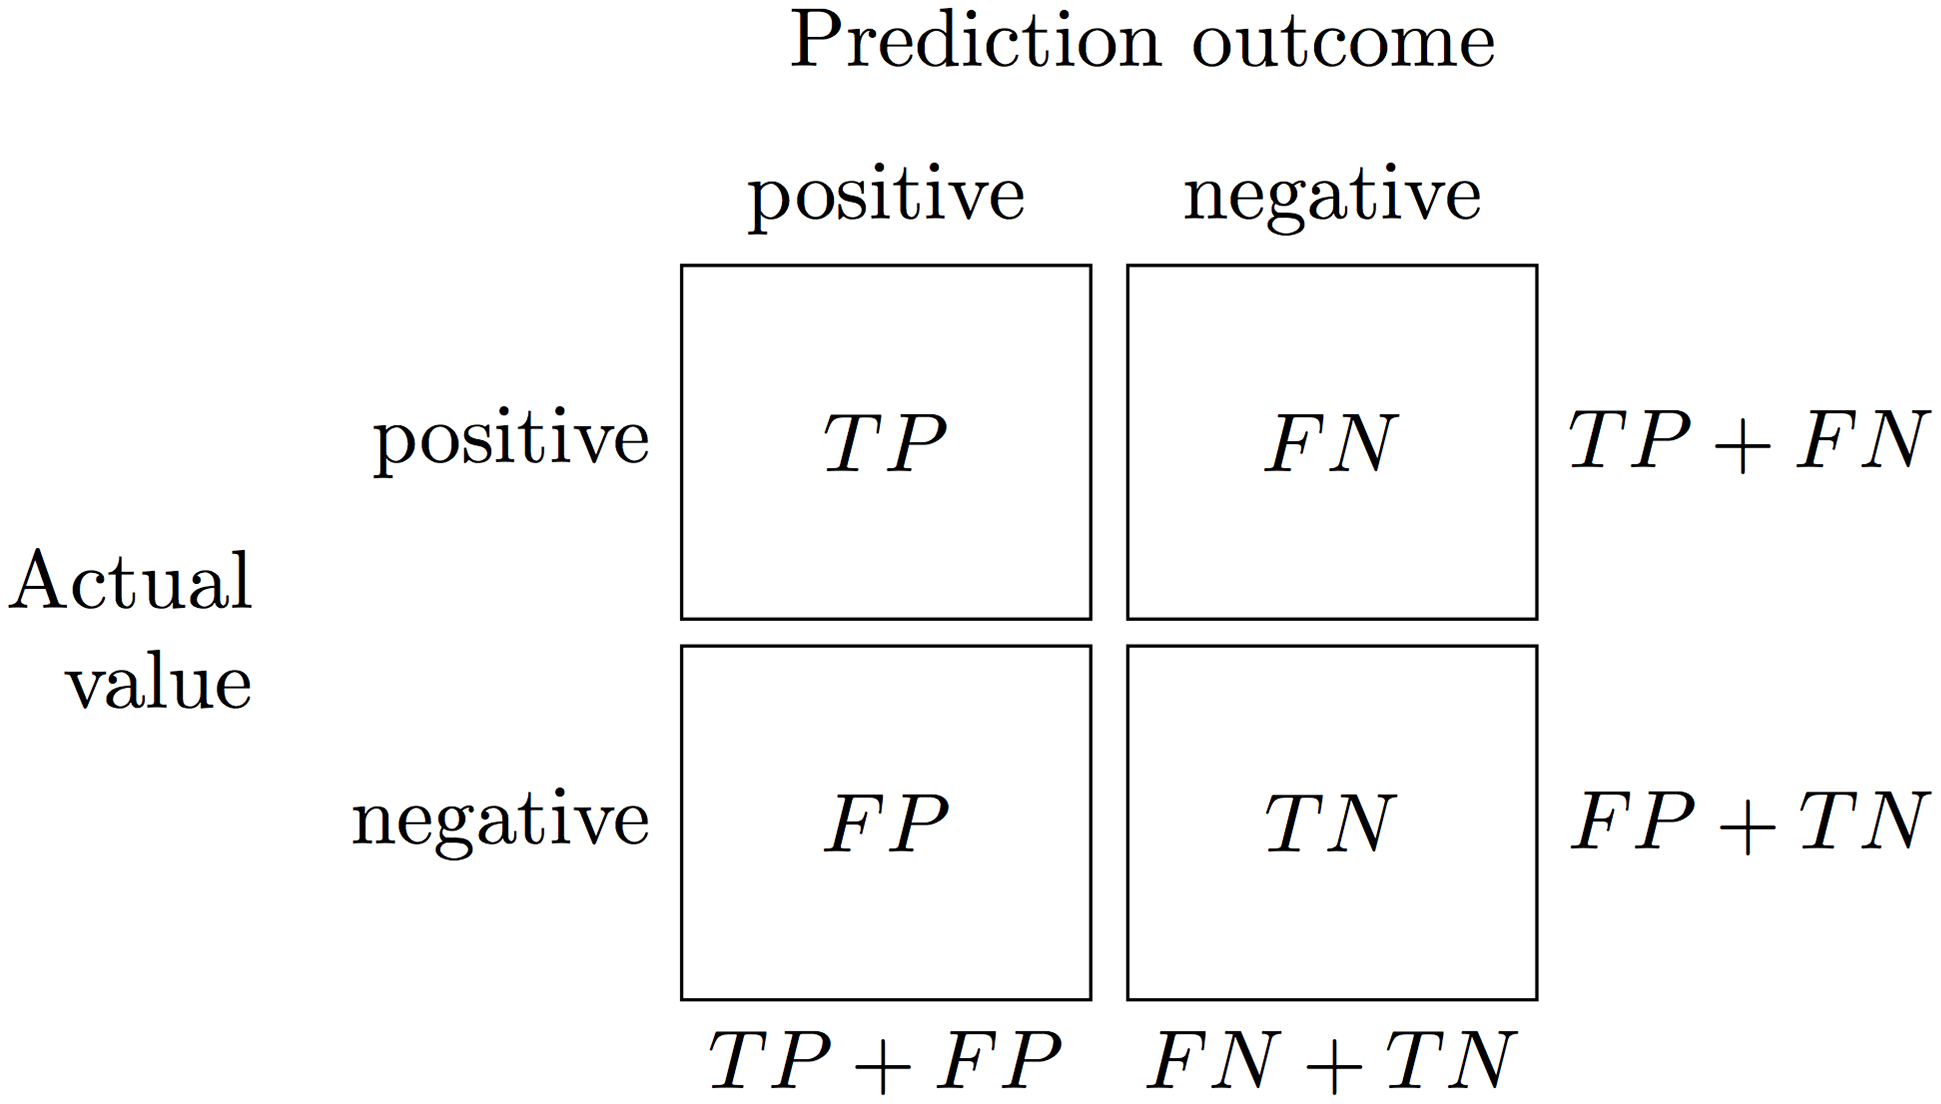

TP — true positive: классификатор верно отнёс объект к рассматриваемому классу.

TN — true negative: классификатор верно утверждает, что объект не принадлежит к рассматриваемому классу.

FP — false positive: классификатор неверно отнёс объект к рассматриваемому классу.

FN — false negative: классификатор неверно утверждает, что объект не принадлежит к рассматриваемому классу.

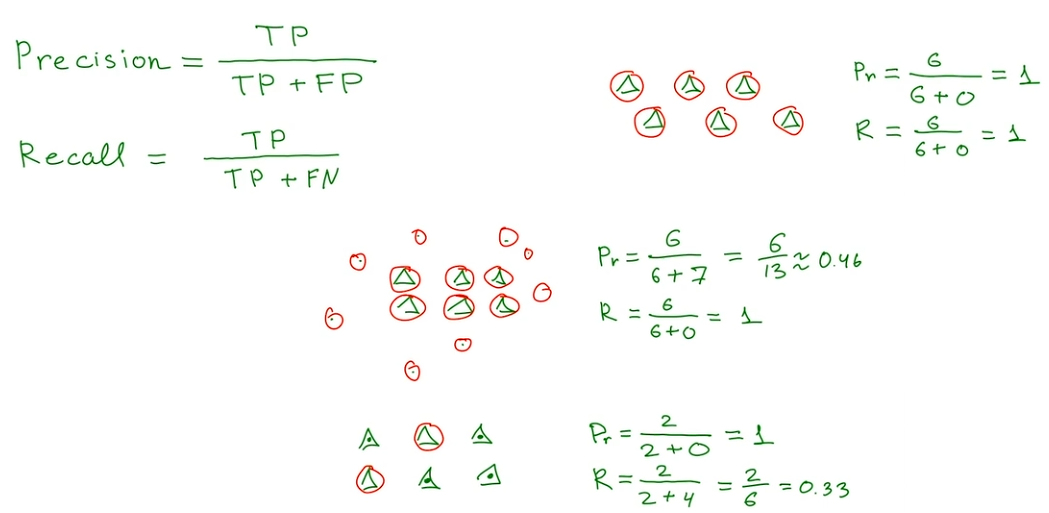

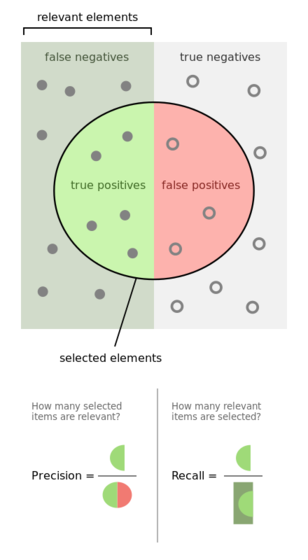

### Precision ('точность') - 
#### 'Переработка', модель перестаралась
Precision уменьшается, когда в модели есть ошибки типа FP (False Positive - Ложно положительные), классификатор отнес к классу, хотя на самом деле объект не принадлежит к нему ('ложные срабатывания'). Если ни разу не сделал ложного срабатывания precision=1.

### Recall ('Полнота') - 
#### 'Недоработка', модель не доработала
Recall уменьшается, когда в модели есть ошибки типа FN (False Negative - Ложно отрицательный), классификатор не относит к классу, то что должно быть отнесено. Правда ли, что модель нашла все положительные примеры

### F-мера

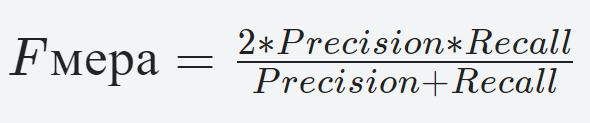

Cреднее гармоническое Precision и Recall. Если хотим увеличить и то и другое, то максимизируем F меру. При этом в F-мере можно задать вес одной из метрик, чтобы предпочтение отдавать одной из них

### Accuracy

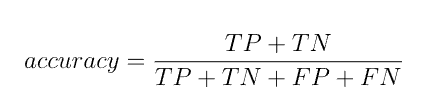

Это доля правильных ответов модели. Почти неиспользуемая метрика. Эта метрика бесполезна в задачах с неравными классами (дисбаланс классов)

Но на практике, зачастую, нам необходимо не максимизировать какую-то одну метрику, а удерживать баланс между разными метриками.

##### _________________________________________________________________________________________________

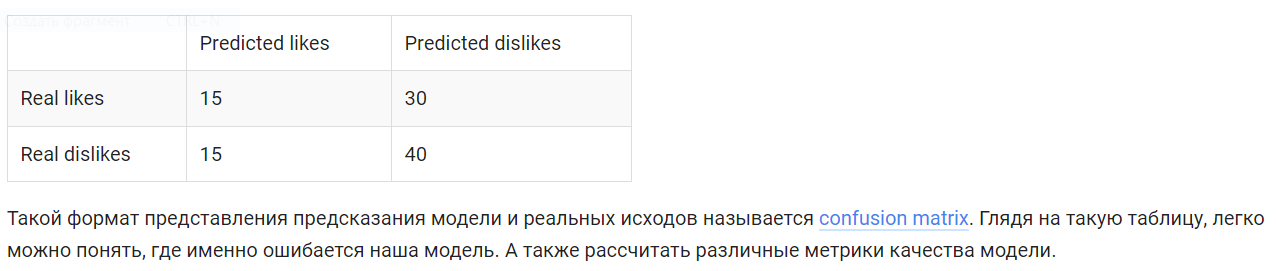

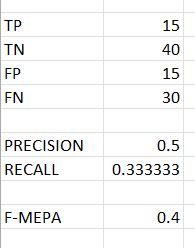

##### Ошибка I рода -  
False Positive (𝛼-ошибка, ложноположительное заключение) — ситуация, когда отвергнута верная нулевая гипотеза. 

##### ____________________________________________________________________________________________________

##### Ошибка II рода -
False Negative (β-ошибка, ложноотрицательное заключение) — ситуация, когда принята неверная нулевая гипотеза.

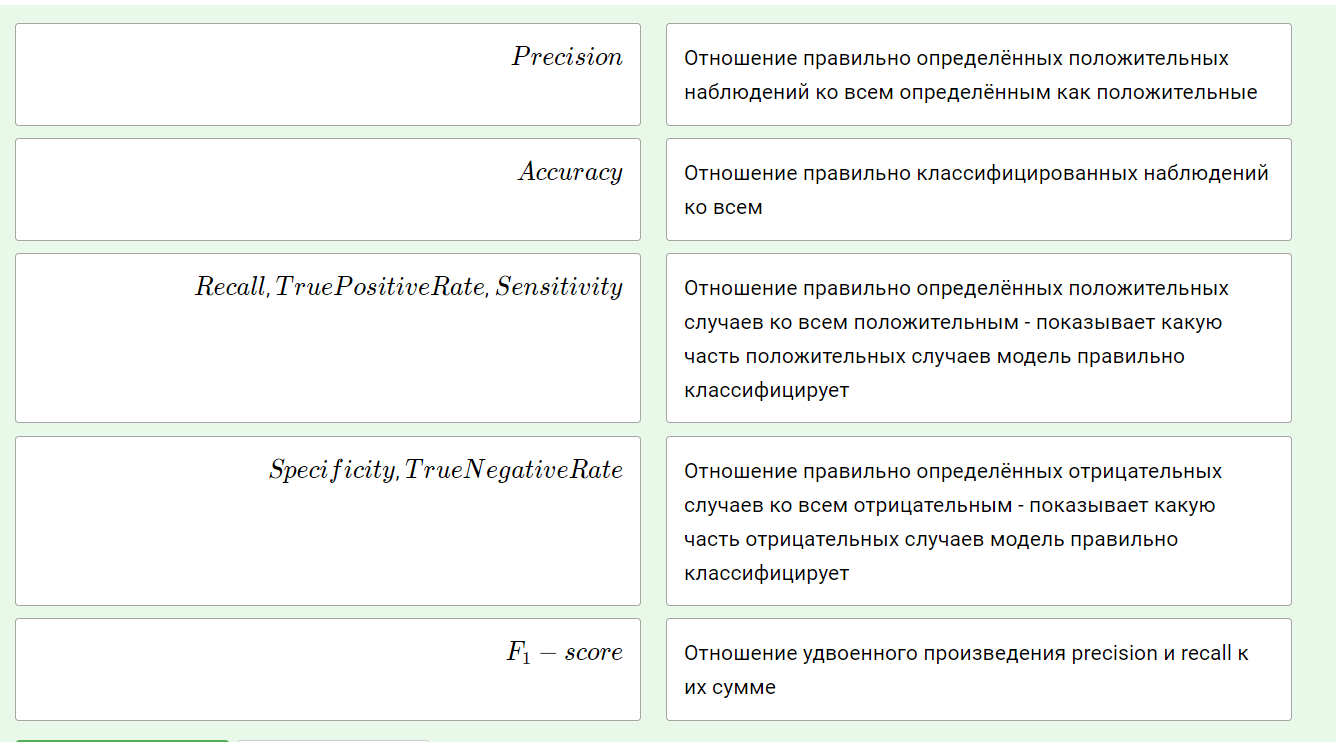

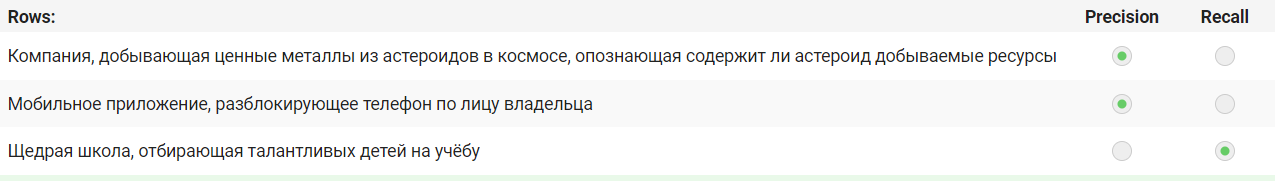

1) Компания не имеет ресурсы, чтобы осматривать каждый астероид. Нельзя растрачивать свои ресурсы впустую, важна метрика Precision. Критично классифицировать то чего нет, т.е. False Positive.


2) Мобильное приложение должно идентифицировать именно пользователь и никого иного. Критична ошибка False Positive - важно не принимать за пользователя чужих людей.


3) Так как школа щедрая, она может позволить себе захватить пару не талантливых детей, это не критично. False Positive - ложно положительная классификация не критична, однако критична, когда школа пропускает талантливого - False Negative - поэтому важнее метрика Recall.

##### ______________________________________________________________________________________________

Поупражняемся в расчётах precision. В задании даны переменные, содержащие информацию о песнях и артистах - X_train, y_train, X_test и y_test. Исходно в датасэтах содержались тексты песен, но Decision Tree работает с категориальными и числовыми переменными, а текст это... текст. Поэтому его необходимо преобразовать в понятную для модели форму. В данном случае для каждой песни просто посчитаны длина и количество некоторых знаков пунктуации.

Обучите модель на тренировочных данных, предскажите авторов для тестовых и поместите в переменную predictions. Затем посчитайте precision score на предсказаниях и y_test, укажите параметр average='micro', и сохраните результат в переменную precision.

Если он будет недостаточно высок, потюньте немного модель.

Исходные данные взяты отсюда, слегка процессированные можно взять здесь (исходные колонки типа жанра, года были выкинуты в задании)

In [112]:
song_df = pd.read_csv('C:\\Users\\UserOfPC\\Documents\\Основы Data Science Stepik\\Датасеты\\songs.csv')

In [113]:
song_df.head()

song  year          artist    genre  \
0            the-ownerz  2007       gangstarr  Hip-Hop   
1  dead-sound-of-misery  2006  blind-guardian    Metal   
2         modred-s-song  2006  blind-guardian    Metal   
3        the-ninth-wave  2015  blind-guardian    Metal   
4                skills  2014       gangstarr  Hip-Hop   

                                              lyrics  length  commas  \
0  "One-two.."\n"One-two, shots to the chin.. kno...    1300      24   
1  It's dark\nLet's do it now\nBring in the siren...    1566       0   
2  I've lost my battle before it starts\nmy first...     996       1   
3  As dark night embraces\nWe are the nation\nI w...    2868       5   
4  Skills, skills, skills\n"My Microphone"\n"It's...    3351      22   

   exclamations  colons  hyphens  
0             5       0       11  
1             0       0        0  
2             0       1        0  
3             0       0        0  
4             0       0        3

In [114]:
song_df = song_df.drop(['song', 'year', 'genre', 'lyrics'], axis=1)

In [115]:
X = song_df.drop('artist', axis=1)
X

length  commas  exclamations  colons  hyphens
0      1300      24             5       0       11
1      1566       0             0       0        0
2       996       1             0       1        0
3      2868       5             0       0        0
4      3351      22             0       0        3
..      ...     ...           ...     ...      ...
355     972       2             0       0        1
356    1283      33             0       0        3
357     810       1             0       0        0
358    1996      34             0       0        5
359     991       8             0       0        0

[360 rows x 5 columns]

In [116]:
y = song_df['artist']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)   

In [118]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=21)

In [119]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=21)

In [120]:
predictions = clf.predict(X_test)

In [121]:
precision = precision_score(y_test, predictions, average='micro')  
# Сколько у модели было ложных срабатываний, чем ближе к 1, тем меньше модель делает ошибок TP

In [122]:
precision

0.7142857142857143

Деревья решений могут решать задачу классификации с произвольным числом классов.


В качестве переменных для обучения дерева могут быть использованы как количественные, так и категориальные признаки.


При прочих равных, чем больше показатель глубины дерева, тем больше риск переобучиться на обучающих данных.

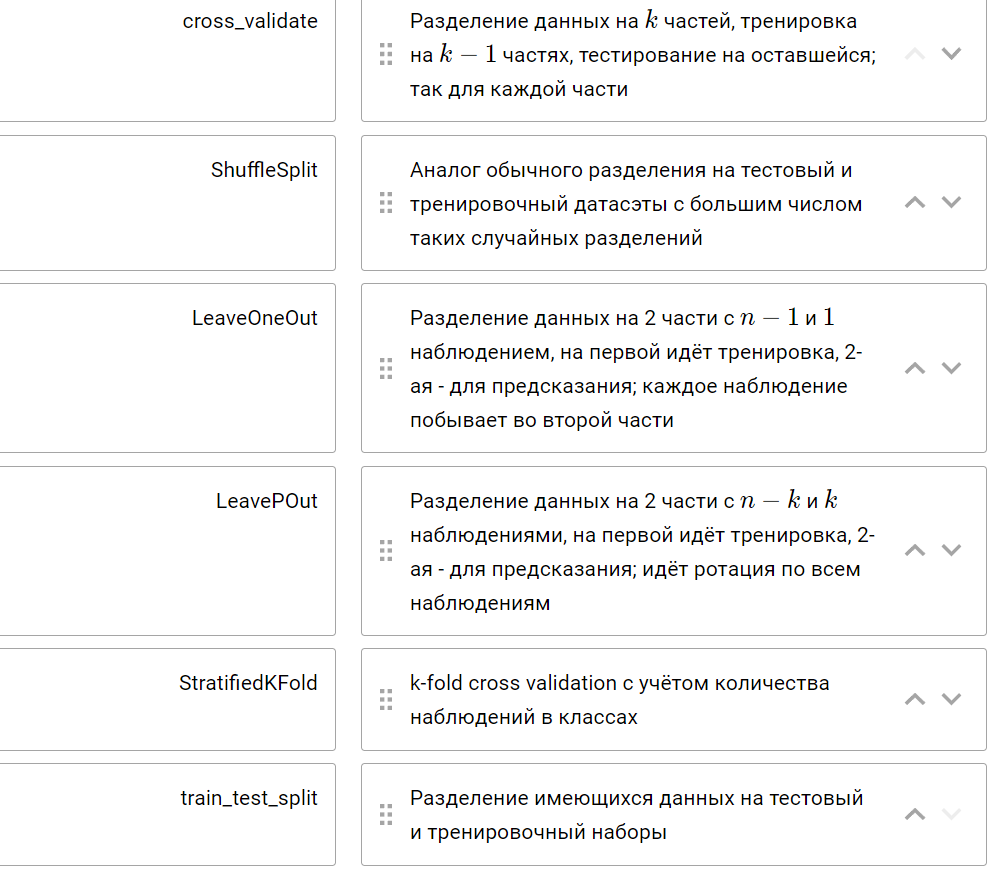

Если расположить в порядке возрастания по затратам вычислительных мощностей на последующие предсказания:

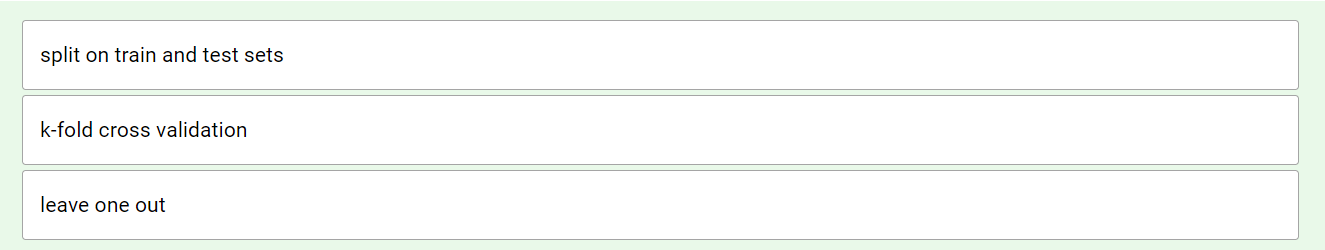

Существуют различные способы вызова кросс-валидации в sklearn, например:

cross_val_predict(estimator, x, y, cv=bar) 

где estimator - предсказывающая модель, а bar - число блоков при k-fold кросс-валидации или объект из sklearn.model_selection, позволяющий осуществлять кросс-валидацию по другой стратегии.


Мы использовали другой способ - GridSearchCV, отбирающий лучшую модель по заданным параметрам, проводя кросс-валидацию.

### min_sample_split 

Параметр, который отвечает на вопрос, какой размер выборки мы будем считать доступным (минимально допустимым), чтобы сделать еще один сплит и спуститься на еще один уровень вниз. Нужен для того, чтобы ограничить минимальный размер выборки для сплита.

### min_samples_leaf

Параметр, который отвечает за ограничение минимального количества элементов в итоговом листе.

In [123]:
clf_titanic = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 3, min_samples_split=100, min_samples_leaf=10)

In [124]:
clf_titanic.fit(X_train_tit, y_train_tit)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

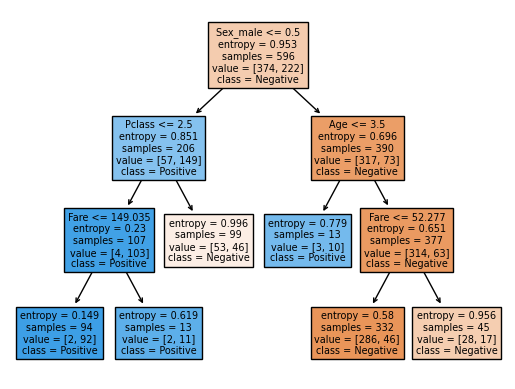

In [125]:
_ = tree.plot_tree(clf_titanic, feature_names=list(X_titanic),
               class_names=['Negative', 'Positive'],
               filled=True)
# _ - чтобы не отображать аннотации для графиков

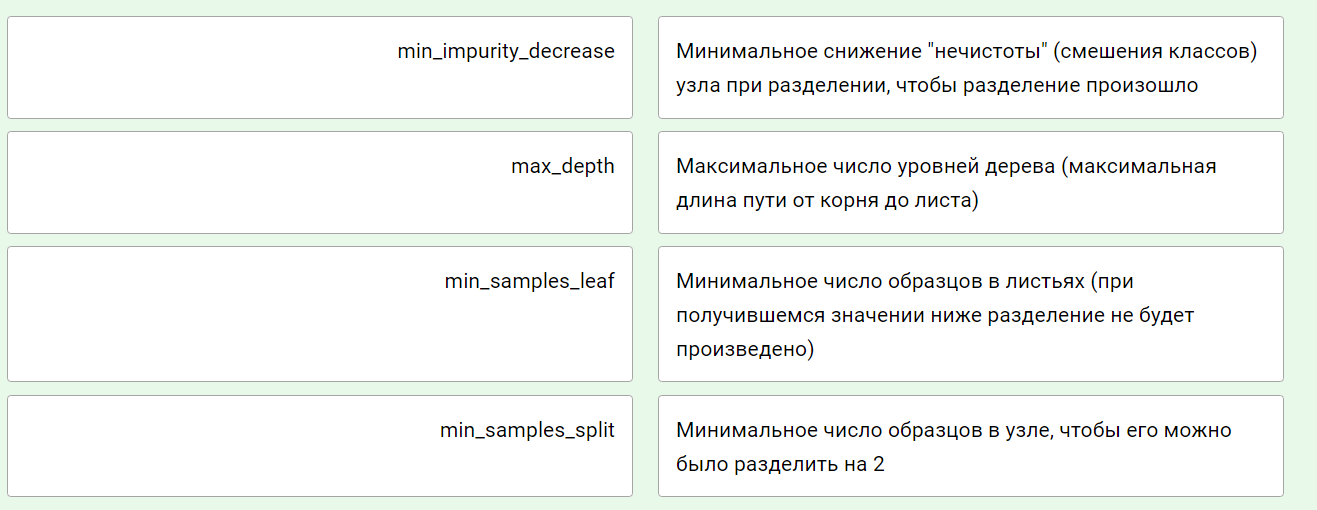

### Заключение.

Дерево решений - алгоритм машинного обучения для регрессии и классификации. Остановимся подробнее на задаче классификатора. В процессе построения дерева выбираются переменные разделение, по которым позволяет нам с большей точностью разделять исследуемые классы. В каждом листе дерева находится одно условие, которое разбивает наш набор данных на два подмножества.


Процесс выбора фичей, которые помещаются в лист дерева основывается на расчете Information gain. Могут использоваться и другие критерии.


По умолчанию классификатор строит настолько глубокое дерево, насколько позволяет набор данных. Таким образом, классификатор преследует цель безошибочно отнести к нужному классу все объекты в выборке. Такой "жадный" алгоритм может приводить к переобучению в результате избыточной глубины дерева.


Проверить насколько сильно переобучен классификатор можно обучив его на обучающей выборке затем проверить качество модели на тестовой выборке.
Основная цель построения любой модели - получить классификатор с максимальной обобщающей способностью, т.е. такой классификатор, который успешно выделяет общие закономерности и не переобучается на частных закономерностях в конкретной выборке.


Для этой цели мы подбираем оптимальный набор параметров классификатора, в случае дерева решений - это может быть глубина дерева. Для выбора оптимального параметра можно построить множество деревьев с разной глубиной и выбрать наилучший результат.


В качестве критерия "наилучшего" классификатора можно использовать кросс-валидацию. При таком подходе данные в выборке разбиваются на n частей, например на 5 частей, далее классификатор обучается на 4 частях данных и валидируется на оставшейся 5ой части. Затем операция повторяется, чтобы каждая из 5 частей данных оказалась в роли тестового множества.

##### Random Forest

Суть алгоритма заключается в том, что он создает множество решающих деревьев и использует их для предсказания классов объектов. Каждое дерево строится на случайном подмножестве обучающих данных и случайном подмножестве признаков. В результате, каждое дерево в ансамбле получается немного разным, что позволяет уменьшить эффект переобучения и повысить качество предсказаний.

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [127]:
clf_rf = RandomForestClassifier()

In [128]:
parametrs = {'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]}

In [129]:
grid_search_cv_clf_rf = GridSearchCV(clf_rf, parametrs, cv=5)

In [130]:
grid_search_cv_clf_rf.fit(X_train_tit, y_train_tit)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [131]:
grid_search_cv_clf_rf.best_params_

{'max_depth': 5, 'n_estimators': 20}

In [132]:
best_clf_rf = grid_search_cv_clf_rf.best_estimator_

In [133]:
best_clf_rf.score(X_test_tit, y_test_tit)

0.8169491525423729

Для каждой фичи можем посмотреть взвешенную метрику того, насколько часто она использовалась для сплитов и приводила к значительному снижению неопределенности в наших данных.

In [134]:
feature_importances = best_clf_rf.feature_importances_

In [135]:
# list(X_train_tit) - 'вытаскивает названия фичей'
feature_importances_df = pd.DataFrame({'features':list(X_train_tit), 
                                        'feature_importances': feature_importances})

In [136]:
feature_importances_df.sort_values('feature_importances', ascending=False)

features  feature_importances
5  Sex_female             0.273296
6    Sex_male             0.234836
4        Fare             0.166202
0      Pclass             0.109369
1         Age             0.107587
2       SibSp             0.032701
3       Parch             0.031988
7  Embarked_C             0.030075
9  Embarked_S             0.008974
8  Embarked_Q             0.004972

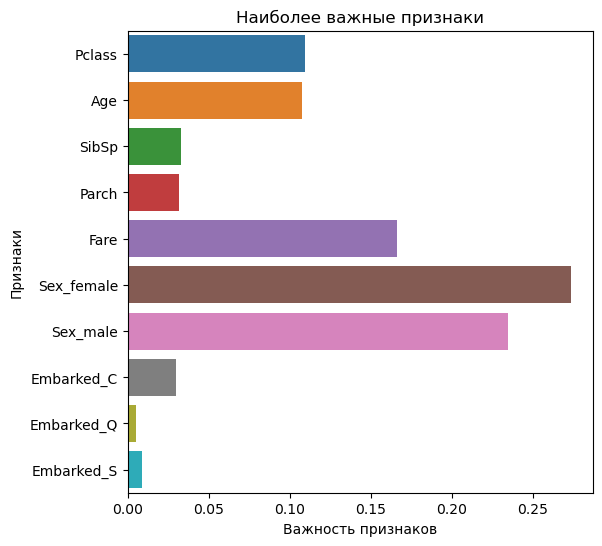

In [137]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=feature_importances_df.features, 
            x=feature_importances_df.feature_importances)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

### Пример на датасете Сердечные заболевания

Воспользуемся данными о сердечных заболеваниях и обучим на них Random Forest. Постройте график важности переменных для классификации и выберите среди предложенных вариантов наиболее похожий.

В задании присутствует рандом, прогоните обучение случайного леса и построение графика несколько раз, чтобы увидеть изменения в важности фичей (5 самых важных обычно присутствуют в топе, просто в разном порядке).
Чтобы получить такой же график, как в правильном варианте ответа, сделайте random.seed(0)

In [138]:
url = "https://raw.githubusercontent.com/sanyathisside/Predicting-Heart-Disease-using-Machine-Learning/master/heart-disease.csv"

df = pd.read_csv(url)
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [139]:
X_train_heart = df.drop('target', axis =1)

In [140]:
y_train_heart = df['target']

In [141]:
np.random.seed(0)

rf = RandomForestClassifier(10, max_depth=5)

In [142]:
rf.fit(X_train_heart, y_train_heart)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [143]:
feature_importances = rf.feature_importances_

In [144]:
feature_importances_rf = pd.DataFrame({'features':list(X_train_heart), 
                                        'feature_importances': feature_importances})

<Axes: >

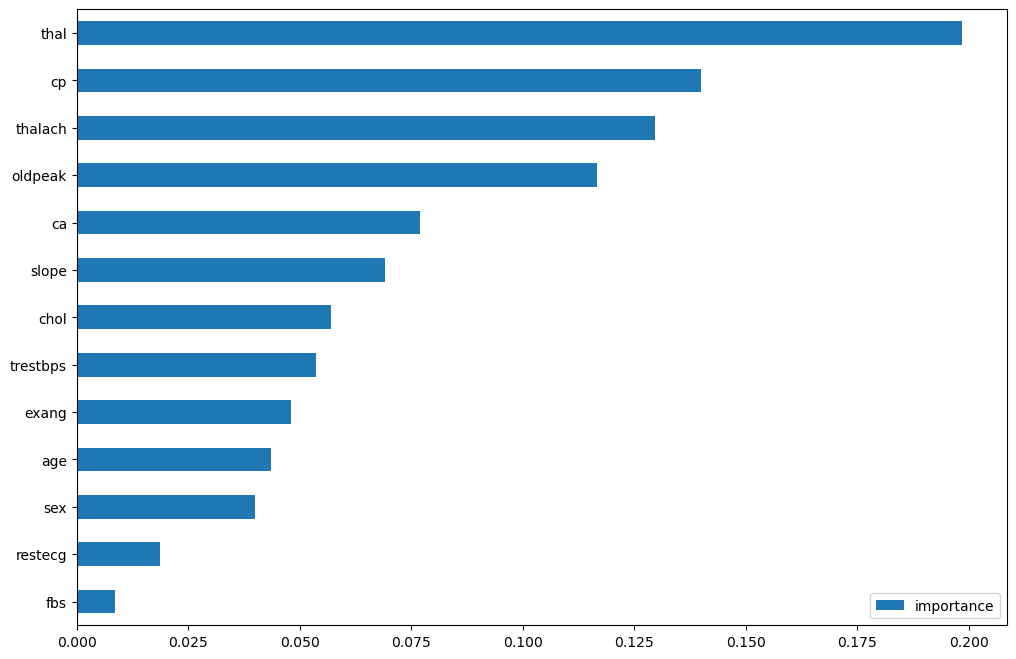

In [145]:
imp = pd.DataFrame(rf.feature_importances_, index=X_train_heart.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))